In [1]:
import sys 
from bfseg.data.fsdata import load_fsdata
import tensorflow as tf
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys
import tensorflow_datasets as tfds
from zipfile import ZipFile
import bfseg.models.fast_scnn
import bfseg.data.hive.office_rumlang_validation_labeled
import bfseg.data.hive.bfseg_validation_labeled
from bfseg.utils.utils import load_gdrive_file
#from bfseg.settings import TMPDIR
TMPDIR = "/home/matthias/data/rss_2021_data/tmp/"
MASKPATH = "/home/matthias/data/rss_2021_data/mask.png"

Segmentation Models: using `tf.keras` framework.


## Load important data

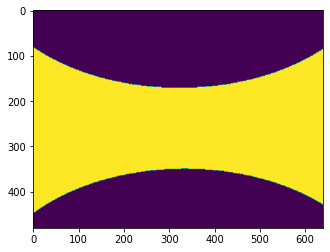

In [63]:
# Load mask
mask = plt.imread(MASKPATH)
ax = plt.subplot()
ax.imshow(mask)
mask_filtered = np.nonzero(mask)
test = mask[mask_filtered]

In [61]:
# Test dataset:
val_ds_office_gt = tfds.load('office_rumlang_validation_labeled', split='OFFICE')

In [62]:
# NYU Depth dataset:
nyu_depth_ds = tfds.load("NyuDepthV2LabeledDepth", split="full[:1%]")

## gt_segmentation_example

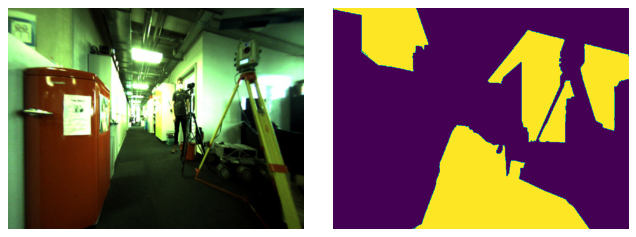

In [5]:
samples_iter = iter(val_ds_office_gt.take(10))
for i in range(3):
    entry1 = next(samples_iter)

figure0 = plt.figure(figsize=(10, 5), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.subplot(1,2,1)
plt.imshow(entry1['image'])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(entry1['label'])
plt.axis('off')

figure0.savefig("presentation_figures/gt_segmentation_example.pdf", bbox_inches='tight')
figure0.savefig("presentation_figures/gt_segmentation_example.png", bbox_inches='tight')


## dense_pseudolabels_example1 (rgb, sparse, dense, depth)

In [49]:
datapath = '/home/matthias/data/rss_2021_data/label_aggregator_dense/labels_lidar/'
if not os.path.exists(os.path.join(datapath, 'dataset_info.json')):
    with open(os.path.join(datapath, 'dataset_info.json'), 'w') as f:
        json.dump({
            'output_shapes': {'rgb': [None, None, 3], 'sparselabels': [None, None], 'denselabels': [None, None], 'combinedlabels': [None, None], 'depthlabels': [None, None], 'unaggregatedlabels': [None, None], 'sparsedepthlabels': [None, None]},
            'output_types': {'rgb': 'uint8', 'sparselabels': 'int32', 'denselabels': 'int32', 'combinedlabels': 'int32', 'depthlabels': 'int32', 'unaggregatedlabels': 'int32', 'sparsedepthlabels': 'int32'}
        }, f)
combined_demo_ds = load_fsdata(datapath)
print(combined_demo_ds)

<FlatMapDataset shapes: {rgb: (None, None, 3), sparselabels: (None, None), denselabels: (None, None), combinedlabels: (None, None), depthlabels: (None, None), unaggregatedlabels: (None, None), sparsedepthlabels: (None, None), filename: ()}, types: {rgb: tf.uint8, sparselabels: tf.int32, denselabels: tf.int32, combinedlabels: tf.int32, depthlabels: tf.int32, unaggregatedlabels: tf.int32, sparsedepthlabels: tf.int32, filename: tf.string}>


(-0.5, 759.5, 399.5, -0.5)

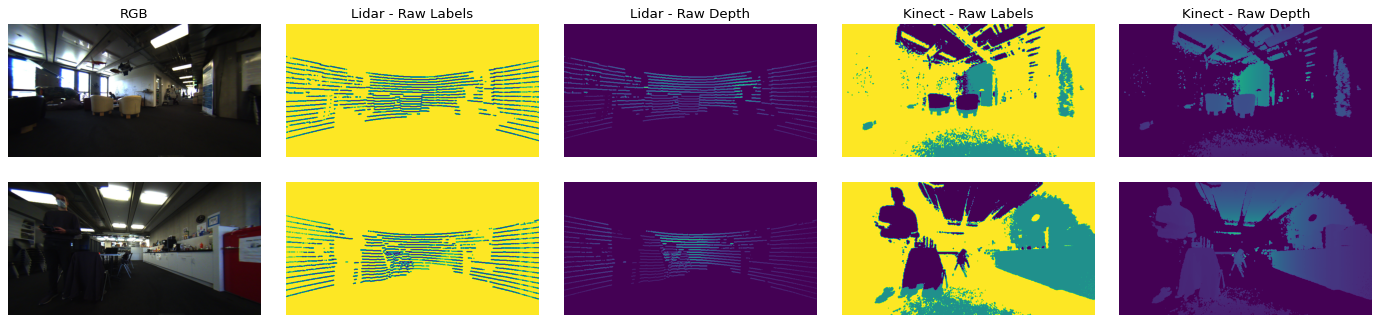

In [103]:
samples_iter1 = iter(combined_demo_ds)
samples_iter2 = iter(combined_demo_ds)
for i in range(60):
    entry1 = next(samples_iter1)
for i in range(100):
    entry2 = next(samples_iter2)
figure0 = plt.figure(figsize=(22, 5), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax1 = plt.subplot(2,5,1)
ax1.imshow(entry1['rgb'])
ax1.set_title('RGB')
plt.axis('off')
ax1 = plt.subplot(2,5,2)
unaggregated = np.where(tf.logical_and(entry1['unaggregatedlabels'] > 0, entry1['unaggregatedlabels'] < int(255/10*0.5)), 1, 2)
unaggregated = np.where(entry1['unaggregatedlabels'] >= int(255/10*0.5), 0, unaggregated)
ax1.imshow(unaggregated)
ax1.set_title('Lidar - Raw Labels')
plt.axis('off')
ax1 = plt.subplot(2,5,3)
ax1.imshow(entry1['sparsedepthlabels'], vmin=0, vmax=255)
ax1.set_title('Lidar - Raw Depth')
plt.axis('off')
ax1 = plt.subplot(2,5,4)
ax1.imshow(entry1['denselabels'])
ax1.set_title('Kinect - Raw Labels')
plt.axis('off')
ax1 = plt.subplot(2,5,5)
ax1.imshow(entry1['depthlabels'], vmin=0, vmax=255)
ax1.set_title('Kinect - Raw Depth')
plt.axis('off')

ax1 = plt.subplot(2,5,6)
ax1.imshow(entry2['rgb'])
plt.axis('off')
ax1 = plt.subplot(2,5,7)
unaggregated = np.where(tf.logical_and(entry2['unaggregatedlabels'] > 0, entry2['unaggregatedlabels'] < int(255/10*0.5)), 1, 2)
unaggregated = np.where(entry2['unaggregatedlabels'] >= int(255/10*0.5), 0, unaggregated)
ax1.imshow(unaggregated)
plt.axis('off')
ax1 = plt.subplot(2,5,8)
ax1.imshow(entry2['sparsedepthlabels'], vmin=0, vmax=255)
plt.axis('off')
ax1 = plt.subplot(2,5,9)
ax1.imshow(entry2['denselabels'])
plt.axis('off')
ax1 = plt.subplot(2,5,10)
ax1.imshow(entry2['depthlabels'], vmin=0, vmax=255)
plt.axis('off')

## dense_pseudolabels_example2 (rgb, sparse, dense, combined)

In [5]:
datapath = '/home/matthias/data/rss_2021_data/label_aggregator_dense/labels_lidar/'
if not os.path.exists(os.path.join(datapath, 'dataset_info.json')):
    with open(os.path.join(datapath, 'dataset_info.json'), 'w') as f:
        json.dump({
            'output_shapes': {'rgb': [None, None, 3], 'sparselabels': [None, None], 'denselabels': [None, None], 'combinedlabels': [None, None], 'depthlabels': [None, None], 'unaggregatedlabels': [None, None], 'sparsedepthlabels': [None, None]},
            'output_types': {'rgb': 'uint8', 'sparselabels': 'int32', 'denselabels': 'int32', 'combinedlabels': 'int32', 'depthlabels': 'int32', 'unaggregatedlabels': 'int32', 'sparsedepthlabels': 'int32'}
        }, f)
combined_demo_ds = load_fsdata(datapath)
print(combined_demo_ds)

<FlatMapDataset shapes: {rgb: (None, None, 3), sparselabels: (None, None), denselabels: (None, None), combinedlabels: (None, None), depthlabels: (None, None), unaggregatedlabels: (None, None), sparsedepthlabels: (None, None), filename: ()}, types: {rgb: tf.uint8, sparselabels: tf.int32, denselabels: tf.int32, combinedlabels: tf.int32, depthlabels: tf.int32, unaggregatedlabels: tf.int32, sparsedepthlabels: tf.int32, filename: tf.string}>


(-0.5, 759.5, 399.5, -0.5)

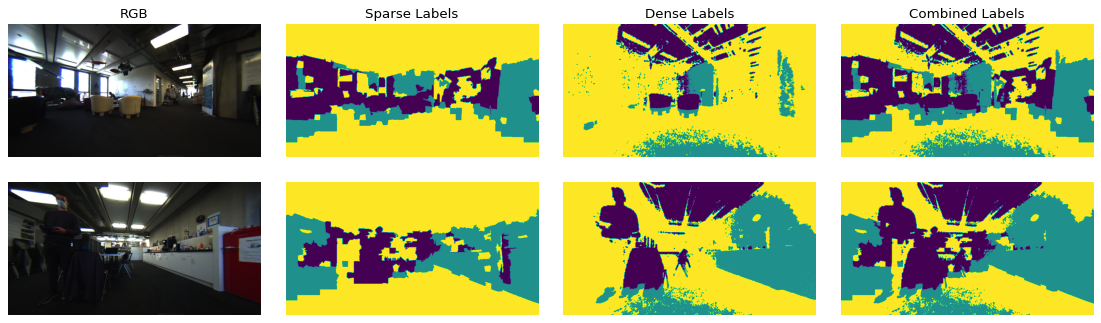

In [101]:
samples_iter1 = iter(combined_demo_ds)
samples_iter2 = iter(combined_demo_ds)
for i in range(60):
    entry1 = next(samples_iter1)
for i in range(100):
    entry2 = next(samples_iter2)
figure0 = plt.figure(figsize=(17.5, 5), dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax1 = plt.subplot(2,4,1)
ax1.imshow(entry1['rgb'])
ax1.set_title('RGB')
plt.axis('off')
ax1 = plt.subplot(2,4,2)
ax1.imshow(entry1['sparselabels'])
plt.axis('off')
ax1.set_title('Sparse Labels')
ax1 = plt.subplot(2,4,3)
ax1.imshow(entry1['denselabels'])
plt.axis('off')
ax1.set_title('Dense Labels')
ax1 = plt.subplot(2,4,4)
ax1.imshow(entry1['combinedlabels'])
plt.axis('off')
ax1.set_title('Combined Labels')

ax1 = plt.subplot(2,4,5)
ax1.imshow(entry2['rgb'])
plt.axis('off')
ax1 = plt.subplot(2,4,6)
ax1.imshow(entry2['sparselabels'])
plt.axis('off')
ax1 = plt.subplot(2,4,7)
ax1.imshow(entry2['denselabels'])
plt.axis('off')
ax1 = plt.subplot(2,4,8)
ax1.imshow(entry2['combinedlabels'])
plt.axis('off')

## visual_results_fastscnn1 (rgb, pretraining, sparse, dense, combined)

In [83]:
pretraining_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_sparse50_dyn_cam2_finetuning_1/model_epoch_initial.h5')
sparse_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_sparse50_dyn_cam2_finetuning_1/model_epoch_10.h5')
dense_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_dense20_dyn_cam2_finetuning_1/model_epoch_5.h5')
combined_model = tf.keras.models.load_model('/home/matthias/data/rss_2021_data/xavier_models/office3_combined2050_dyn_cam2_finetuning_1/model_epoch_6.h5')

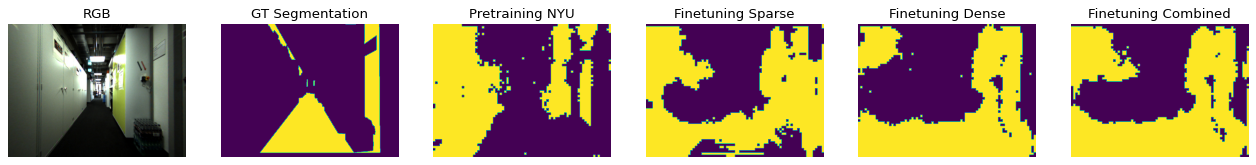

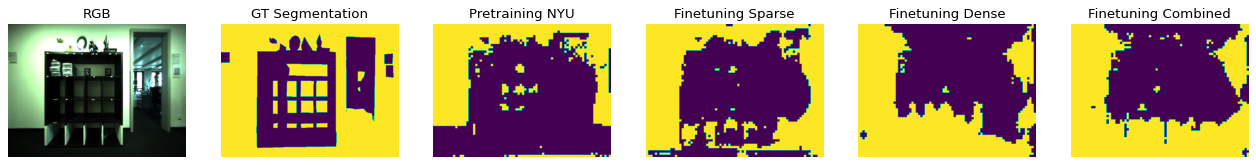

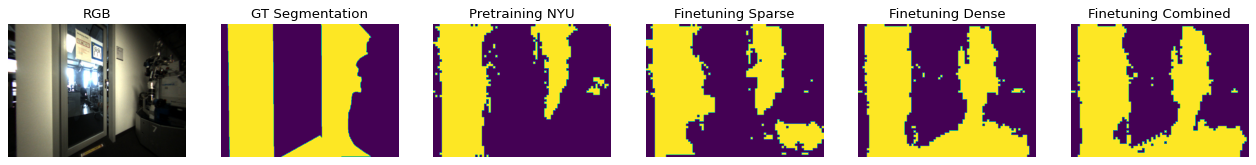

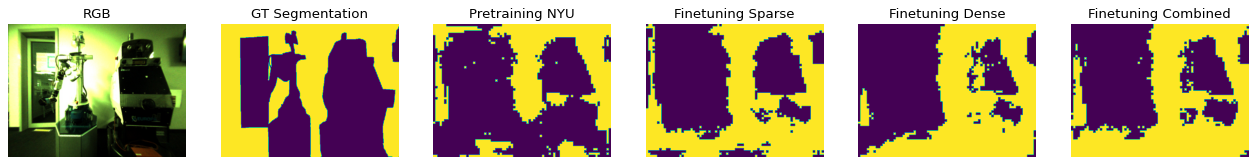

In [98]:
## best images

samples_iter1 = iter(val_ds_office_gt)
samples_iter2 = iter(val_ds_office_gt)
entries = list()

index = 25
for i in range(index):
    entry = next(samples_iter1)
    if i > index - 5:
        entries.append(entry)
"""
for i in range(4):
    entry1 = next(samples_iter1)
for i in range(5):
    entry2 = next(samples_iter2)
entries.append(entry1)
entries.append(entry2)
"""
    
for entry in entries:
    figure = plt.figure(figsize=(20, 5), dpi=80)
    # RGB
    ax1 = plt.subplot(1,6,1)
    ax1.imshow(entry['image'])
    ax1.set_title('RGB')
    plt.axis('off')
    # GT Segmentation
    ax1 = plt.subplot(1,6,2)
    plt.axis('off')
    ax1.imshow(entry['label'])
    ax1.set_title('GT Segmentation')
    # Pretrained Segmentation
    ax1 = plt.subplot(1,6,3)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = pretraining_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:])
    ax1.set_title('Pretraining NYU')
    # Sparse Segmentation
    ax1 = plt.subplot(1,6,4)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = sparse_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:])
    ax1.set_title('Finetuning Sparse')
    # Dense Segmentation
    ax1 = plt.subplot(1,6,5)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = dense_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:])
    ax1.set_title('Finetuning Dense')
    # Combined Segmentation
    ax1 = plt.subplot(1,6,6)
    plt.axis('off')
    a = tf.image.convert_image_dtype(tf.expand_dims(entry['image'],axis=0), tf.float32)
    b = combined_model(a)
    pred = tf.argmax(b[1], axis=-1)
    ax1.imshow(pred[0,:,:])
    ax1.set_title('Finetuning Combined')

## visual_results_fastscnn+depth_nyu1 (rgb, gt_seg, pred_seg, gt_depth, pred_depth)

## visual_results_fastscnn+depth_1 (rbg, gt_seg, pred_seg, pred_depth)